In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh

from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 


In [12]:

def get_parameters():
    """Returns parameters used by compute trajectory and fitness functions.

    Returns:
        args (dotmap.Dotmap): Dotmap with parameters used for the tests.
    """
    args = DotMap(
        body = DotMap(_dynamic=False),
        integrator = DotMap(_dynamic=False),
        problem = DotMap(_dynamic=False),
        mesh = DotMap(_dynamic=False),
        _dynamic=False)

    # Setup body parameters
    args.body.density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.mu = 665.666                   # Gravitational parameter for 67P/C-G
    args.body.declination = 64               # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.right_ascension = 69           # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_period = 12.06*3600       # [seconds] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_velocity = (2*pi)/args.body.spin_period
    args.body.spin_axis = setup_spin_axis(args)

    # Setup specific integrator parameters:
    args.integrator.algorithm = 3
    args.integrator.dense_output = True
    args.integrator.rtol = 1e-12
    args.integrator.atol = 1e-12

    # Setup problem parameters
    args.problem.start_time = 0                     # Starting time [s]
    args.problem.final_time = 20*3600.0             # Final time [s]
    args.problem.initial_time_step = 600            # Initial time step size for integration [s]
    args.problem.activate_event = True              # Event configuration (0 = no event, 1 = collision with body detection)
    args.problem.number_of_maneuvers = 0 
    args.problem.target_squared_altitude = 8000**2  # Target altitude squared [m]
    args.problem.activate_rotation = False


    # Arguments concerning bounding spheres
    args.problem.measurement_period = 100                # Period for when a measurement sphere is recognized and managed. Unit: [seconds]
    args.problem.radius_inner_bounding_sphere = 4000      # Radius of spherical risk-zone for collision with celestial body [m]
    args.problem.radius_outer_bounding_sphere = 10000
    args.problem.squared_volume_inner_bounding_sphere = (4/3) * pi * (args.problem.radius_inner_bounding_sphere**3)
    args.problem.squared_volume_outer_bounding_sphere = (4/3) * pi * (args.problem.radius_outer_bounding_sphere**3)
    args.problem.measurable_volume = args.problem.squared_volume_outer_bounding_sphere - args.problem.squared_volume_inner_bounding_sphere

    args.problem.maximal_measurement_sphere_volume = (4/3) * pi * (35.95398913**3)

    # Create mesh of body.
    args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = create_mesh()

    return args

In [33]:
v_max = (4/3) * pi * (35.95398913**3)
v = 1824979272.668944 #910431867.2583148
n = 720
print("V_max: ", v_max)
print("n*V_max: ", n*v_max)
print(v/(v_max*n))

V_max:  194683.8193152704
n*V_max:  140172349.9069947
13.019538260433173


In [32]:
args = get_parameters()
x = [9.16234255e+03, 1.73917660e-02, 3.03363317e+00, 3.57741462e+00, 5.49214728e+00, 4.73909083e+00]

_, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, _, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)

fitness_func = [FitnessFunctions.TargetAltitudeDistance, FitnessFunctions.CloseDistancePenalty, FitnessFunctions.FarDistancePenalty, FitnessFunctions.CoveredVolume, FitnessFunctions.CoveredVolumeFarDistancePenalty, FitnessFunctions.CoveredVolumeCloseDistancePenaltyFarDistancePenalty]
scaled_positions = np.empty((3*len(fitness_func), len(timesteps)), dtype=np.float64)
fitness_perturbation = np.arange(0,3,0.1)

fitness_array = np.empty((len(fitness_func), len(fitness_perturbation)))

for func_counter, func in enumerate(fitness_func):
    for perturb_counter, perturbation in enumerate(fitness_perturbation): # or some sensible range, you choose
        scaled_pos = perturbation*positions
        fitness = get_fitness(func, args, scaled_pos, timesteps)
        fitness_array[func_counter, perturb_counter] = fitness
        
       

In [34]:
fitness = get_fitness(FitnessFunctions.TargetAltitudeDistance, args, positions, timesteps)
print(fitness)

0.8133667402826126


[Text(0.5, 0, 'Scaling factor'),
 Text(0, 0.5, 'Fitness'),
 Text(0.5, 1.0, 'CoveredVolumeCloseDistancePenaltyFarDistancePenalty')]

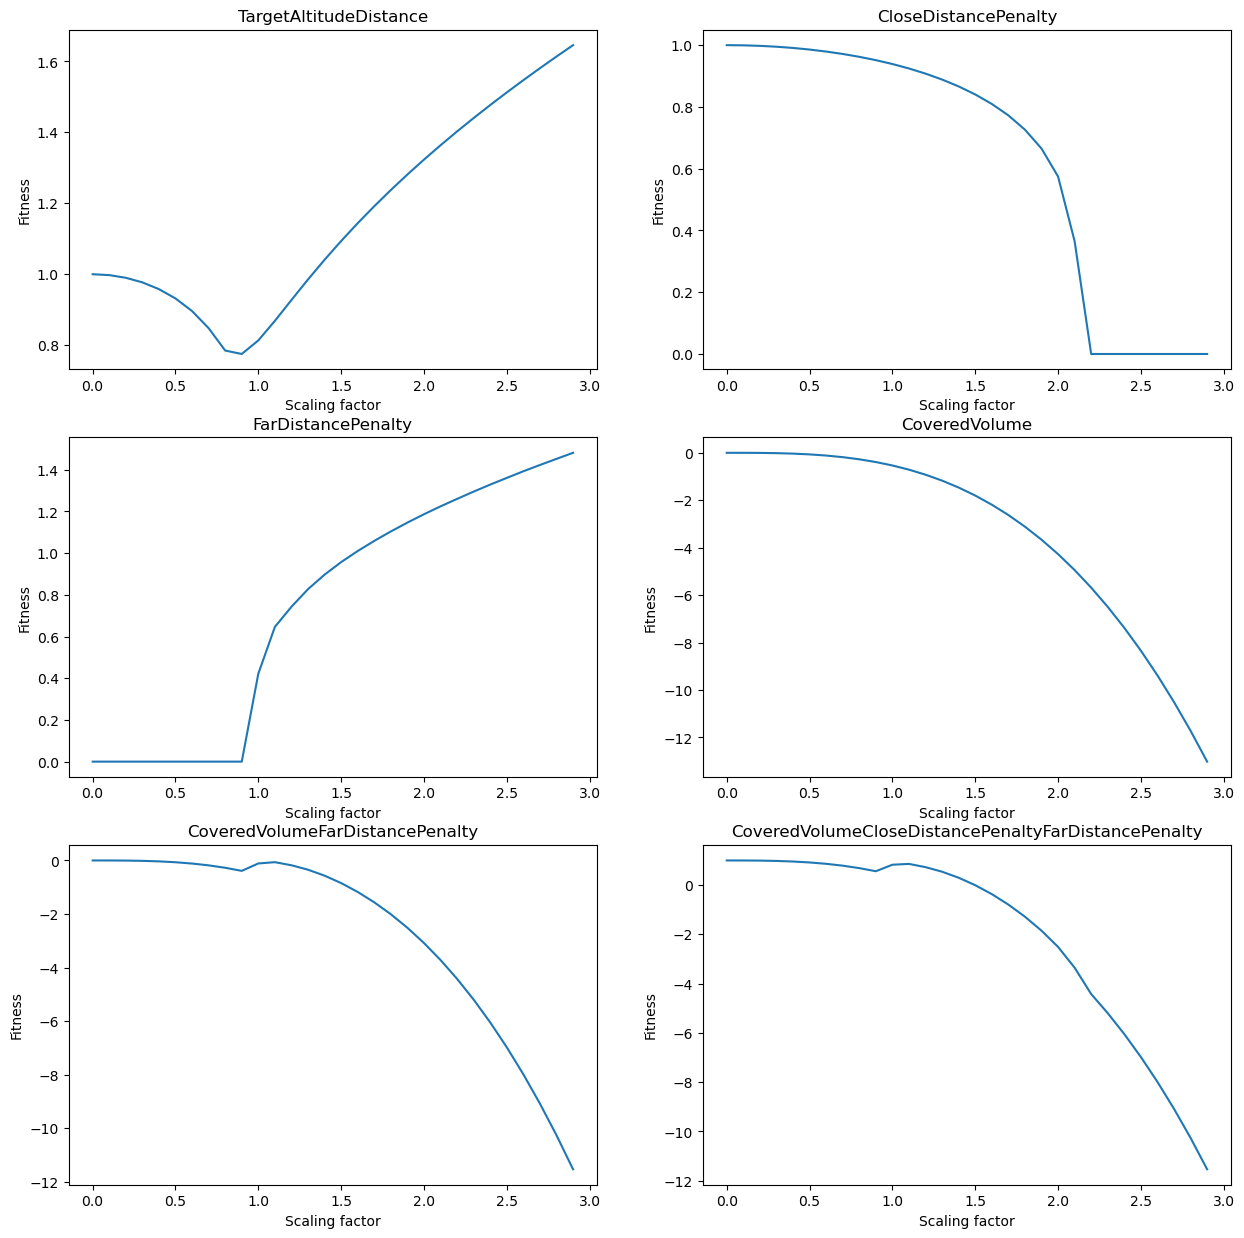

In [35]:


fig, axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0,0].plot(fitness_perturbation, fitness_array[0,:])
axes[0,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='TargetAltitudeDistance')

axes[0,1].plot(fitness_perturbation, fitness_array[1,:])
axes[0,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CloseDistancePenalty')

axes[1,0].plot(fitness_perturbation, fitness_array[2,:])
axes[1,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='FarDistancePenalty')

axes[1,1].plot(fitness_perturbation, fitness_array[3,:])
axes[1,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredVolume')

axes[2,0].plot(fitness_perturbation, fitness_array[4,:])
axes[2,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredVolumeFarDistancePenalty')

axes[2,1].plot(fitness_perturbation, fitness_array[5,:])
axes[2,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredVolumeCloseDistancePenaltyFarDistancePenalty')
